# Consumer Reviews Summarization - Project Part 3


[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/Ariamestra/ConsumerReviews/blob/main/project_part3.ipynb)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Ariamestra/ConsumerReviews/blob/main/project_part3.ipynb)


## 1. Introduction
My goal for this project is to develop a system capable of generating concise summaries of customer reviews. This will help users in quickly skim through feedback on products by transforming detailed reviews into short comments. These comments will be categorized as positive, neutral, or negative, corresponding to the sentiment of the rating provided. To achieve this, the system will use the capabilities of the pre-trained T5 model. I selected the T5 model as my pre-trained choice because it is a text-to-text transformer, thats good at tasks like summarization. I opted for [T5-small](https://huggingface.co/t5-small) due to its size, which is more manageable. Additionally, T5 is versatile in handling different summarization types, like extractive summarization where it picks out important sentences from the text.<br>
<br>

**Data** <br>
The dataset was sourced from Kaggle, specifically the [Consumer Review of Clothing Product](https://www.kaggle.com/datasets/jocelyndumlao/consumer-review-of-clothing-product)
 dataset. This dataset includes customer reviews from Amazon. It has all sorts of feedback from buyers about different products. Along with the customers' actual reviews, ratings, product type, material, construction, color, finish, and durability.<br>



In [20]:
# Import all packages needed
#!pip install transformers pandas nltk scikit-learn
#!pip install sentencepiece
#!pip install transformers[torch]

import pandas as pd
import re
import nltk
import torch
import sys
import sentencepiece as spm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from transformers import T5ForConditionalGeneration, T5Tokenizer
from sklearn.model_selection import train_test_split
import string



nltk.download('punkt')       
nltk.download('stopwords')  
nltk.download('wordnet')     

MODEL_NAME = 't5-small'
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

data_URL = 'https://raw.githubusercontent.com/Ariamestra/ConsumerReviews/main/Reviews.csv'
df = pd.read_csv(data_URL)
print(f"Shape: {df.shape}")
df.head()

[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Shape: (49338, 9)


,Title,Review,Cons_rating,Cloth_class,Materials,Construction,Color,Finishing,Durability
0,NaN,Absolutely wonderful - silky and sexy and comf...,4.0,Intimates,0.0,0.0,0.0,1.0,0.0
1,NaN,Love this dress! it's sooo pretty. i happene...,5.0,Dresses,0.0,1.0,0.0,0.0,0.0
2,Some major design flaws,I had such high hopes for this dress and reall...,3.0,Dresses,0.0,0.0,0.0,1.0,0.0
3,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5.0,Pants,0.0,0.0,0.0,0.0,0.0
4,Flattering shirt,This shirt is very flattering to all due to th...,5.0,Blouses,0.0,1.0,0.0,0.0,0.0


The Kernel crashed while executing code in the the current cell or a previous cell. Please review the code in the cell(s) to identify a possible cause of the failure.

Model training

In [21]:
# Count the number of nulls in reviews
number_of_nulls = df['Review'].isnull().sum()
print(f"Number of nulls in the reviews: {number_of_nulls}")

# Calculate the number of nulls in rating
number_of_nulls_in_ratings = df['Cons_rating'].isnull().sum()
print(f"Number of nulls in the ratings: {number_of_nulls_in_ratings}")

original_count = df.shape[0]
df_cleaned = df.dropna(subset=['Review', 'Cons_rating']) # Drop rows with nulls in reviews and ratings columns
cleaned_count = df_cleaned.shape[0] # Number of rows after dropping nulls
rows_dropped = original_count - cleaned_count

print(f"Number of rows dropped: {rows_dropped}")

# Get the shape after dropping null values
df_shape_after_dropping = df_cleaned.shape

print(f"Shape of the DataFrame after dropping rows: {df_shape_after_dropping}")

Number of nulls in the reviews: 831
Number of nulls in the ratings: 214
Number of rows dropped: 1043
Shape of the DataFrame after dropping rows: (48295, 9)


In [22]:
# Review length of reviews
df_cleaned = df_cleaned.copy()
df_cleaned['Review_length'] = df_cleaned['Review'].apply(lambda x: len(str(x).split()))

# Filter out reviews that are shorter than 20 words 
df_cleaned.drop(df_cleaned[df_cleaned['Review_length'] < 30].index, inplace=True)

# Longest and shortest reviews in df_cleaned
longest_review_row = df_cleaned.loc[df_cleaned['Review_length'].idxmax()]
longest_review = longest_review_row['Review']
longest_review_length = longest_review_row['Review_length']

shortest_review_row = df_cleaned.loc[df_cleaned['Review_length'].idxmin()]
shortest_review = shortest_review_row['Review']
shortest_review_length = shortest_review_row['Review_length']

print(f"Longest review length: {longest_review_length} words")
print(f"Shortest review length: {shortest_review_length} words")
print(f"Shape of the DataFrame after dropping rows below 20 words: {df_cleaned.shape}")

Longest review length: 668 words
Shortest review length: 30 words
Shape of the DataFrame after dropping rows below 20 words: (26680, 10)


In [23]:
# Clean reviews
import string

# Drop columns that are not needed
columns_to_drop = ['Cloth_class', 'Title', 'Materials', 'Construction', 'Color', 'Finishing', 'Durability']
columns_to_drop = [col for col in columns_to_drop if col in df_cleaned.columns]
df_cleaned.drop(columns=columns_to_drop, inplace=True)

stop_words = set(stopwords.words('english'))

def clean_review(review):
    review = str(review).lower()
    review = review.translate(str.maketrans('', '', string.punctuation))
    words = word_tokenize(review)
    words = [word for word in words if word.isalpha() and word not in stop_words]
    return ' '.join(words)

# Apply the cleaning  to Reviews
df_cleaned['Processed_Review'] = df_cleaned['Review'].apply(clean_review)

# Calculate the review lengths 
df_cleaned['Review_length'] = df_cleaned['Processed_Review'].apply(lambda x: len(x.split()))

# Drop the reviews shorter than 20 words
df_cleaned.drop(df_cleaned[df_cleaned['Review_length'] < 20].index, inplace=True)

# Print results
print("Shape after dropping rows:", df_cleaned.shape)
print(df_cleaned.head())


Shape after dropping rows: (21011, 4)
                                              Review  Cons_rating  \
1  Love this dress!  it's sooo pretty.  i happene...          5.0   
2  I had such high hopes for this dress and reall...          3.0   
5  I love tracy reese dresses, but this one is no...          2.0   
6  I aded this in my basket at hte last mintue to...          5.0   
7  I ordered this in carbon for store pick up, an...          4.0   

   Review_length                                   Processed_Review  
1             30  love dress sooo pretty happened find store im ...  
2             48  high hopes dress really wanted work initially ...  
5             39  love tracy reese dresses one petite feet tall ...  
6             48  aded basket hte last mintue see would look lik...  
7             51  ordered carbon store pick ton stuff always try...  


In [24]:
# TF-IDF vectorization and then splits the dataset

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import string

df_cleaned['Processed_Review'] = df_cleaned['Review'].apply(clean_review)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(df_cleaned['Processed_Review'], df_cleaned['Cons_rating'], test_size=0.2, random_state=42)

# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', max_df=0.95, min_df=0.05)

# Fit to the training data 
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

X = df_cleaned['Processed_Review']
y = df_cleaned['Cons_rating']

# Now you can proceed with your existing train-test split -----------------------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate the total number 
total_samples = X.shape[0]
train_size = X_train.shape[0]
test_size = X_test.shape[0]

train_percentage = (train_size / total_samples) * 100
test_percentage = (test_size / total_samples) * 100

print(f"Total dataset size: {total_samples}")
print(f"Train size: {train_size} ({train_percentage:.2f}%)")
print(f"Test size: {test_size} ({test_percentage:.2f}%)")

Total dataset size: 21011
Train size: 16808 (80.00%)
Test size: 4203 (20.00%)


In the provided code, L1 regularization is applied to a logistic regression model to enhance feature selection and reduce overfitting. The process involves running a grid search to tune the regularization strength (`C`) and selecting the optimal parameters based on the best accuracy and log loss. Specifically, `l1_results` filters the grid search outcomes for L1-regularized models. The code identifies the hyperparameter set that yields the highest accuracy and the lowest log loss, outputs these values, and then visualizes the model's performance across various regularization strengths. This visualization shows how different levels of L1 regularization affect the model, assisting in the selection of the most effective regularization level for robust and generalizable predictions.

Model Training

/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best Accuracy: 0.5484177968118011, Best C for Accuracy: 11.288378916846883
Best Log Loss: 1.104366134365715, Best C for Log Loss: 11.288378916846883
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


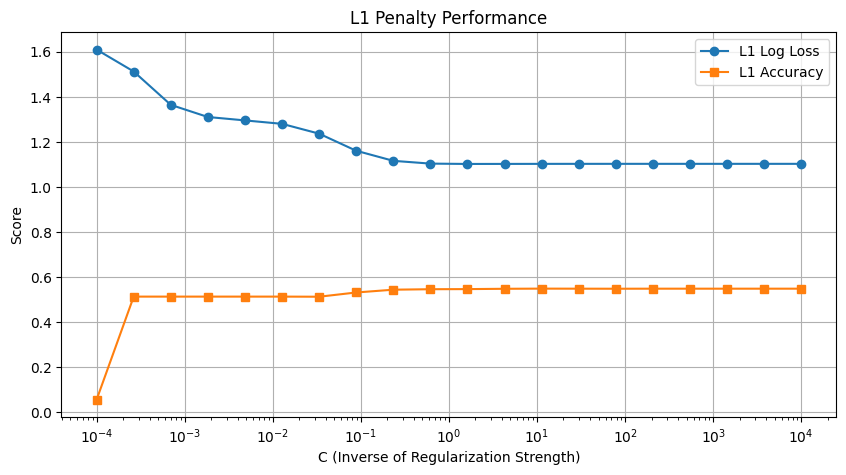

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, log_loss
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Define the model
lr_model = LogisticRegression(random_state=42)

# Fit the model to the training data
lr_model.fit(X_train_tfidf, y_train_encoded)

# Predict probabilities on the test set using the fitted model
y_pred_proba = lr_model.predict_proba(X_test_tfidf)

# Calculate the log loss (cross-entropy loss)
loss = log_loss(y_test_encoded, y_pred_proba)

# Define the model and parameters
lr = LogisticRegression(random_state=42)
param_grid = {
    'C': np.logspace(-4, 4, 20),  # 20 values between 10^-4 and 10^4
    'penalty': ['l1', 'l2'],  # l1 and l2 regularization
    'solver': ['liblinear']  # 'liblinear' works well with l1 and l2
}

# Initialize Grid Search
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, scoring='neg_log_loss')
grid_search.fit(X_train_tfidf, y_train_encoded)

# Get the best parameters and the corresponding log loss
best_params = grid_search.best_params_
best_log_loss = -grid_search.best_score_

# Fit and evaluate GridSearchCV
grid_search.fit(X_train_tfidf, y_train_encoded)

# Get CV results
cv_results = grid_search.cv_results_

# Create a DataFrame from the CV results
results_df = pd.DataFrame(cv_results)

# Add a new column for test set accuracy for each hyperparameter combination
test_accuracies = []
log_losses = []
for i in range(results_df.shape[0]):
    # Retrieve the model
    model = grid_search.best_estimator_.set_params(**results_df.loc[i, 'params'])

    # Fit and predict
    model.fit(X_train_tfidf, y_train_encoded)
    y_pred = model.predict(X_test_tfidf)
    y_pred_proba = model.predict_proba(X_test_tfidf)

    # Calculate and store accuracy and log loss
    test_accuracies.append(accuracy_score(y_test_encoded, y_pred))
    log_losses.append(log_loss(y_test_encoded, y_pred_proba))

results_df['test_accuracy'] = test_accuracies
results_df['test_log_loss'] = log_losses

# Find the best accuracy and corresponding log loss
best_accuracy_index = np.argmax(results_df['test_accuracy'])
best_accuracy = results_df['test_accuracy'][best_accuracy_index]
best_C_for_accuracy = results_df['param_C'][best_accuracy_index]

# Find the index and value of the best log loss and corresponding C value
best_log_loss_index = np.argmin(results_df['test_log_loss'])
best_log_loss = results_df['test_log_loss'][best_log_loss_index]
best_C_for_log_loss = results_df['param_C'][best_log_loss_index]

print(f"Best Accuracy: {best_accuracy}, Best C for Accuracy: {best_C_for_accuracy}")
print(f"Best Log Loss: {best_log_loss}, Best C for Log Loss: {best_C_for_log_loss}")
print('-' * 200)

# Separate data for l1 penalty (assuming you are only using L1)
l1_data = results_df[results_df['param_penalty'] == 'l1']

# Plotting
plt.figure(figsize=(10, 5))

# Plot for L1 penalty
plt.plot(l1_data['param_C'], -l1_data['mean_test_score'], label='L1 Log Loss', marker='o')
plt.plot(l1_data['param_C'], l1_data['test_accuracy'], label='L1 Accuracy', marker='s')
plt.xscale('log')
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('Score')
plt.title('L1 Penalty Performance')
plt.legend()
plt.grid(True)

plt.show()

Model Evaluation

Model Tuning

Accuracy: 0.5479419462288841
Log Loss: 1.1043891496458582
Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.15      0.21       234
           1       0.22      0.06      0.09       319
           2       0.32      0.21      0.26       540
           3       0.40      0.17      0.24       954
           4       0.61      0.91      0.73      2156

    accuracy                           0.55      4203
   macro avg       0.38      0.30      0.31      4203
weighted avg       0.48      0.55      0.48      4203

Confusion Matrix:
[[  36   17   39   20  122]
 [  28   18   73   33  167]
 [  17   22  114   78  309]
 [  10   12   82  164  686]
 [  15   13   46  111 1971]]


Best Parameters: {'C': 0.615848211066026, 'penalty': 'l1', 'solver': 'liblinear'}


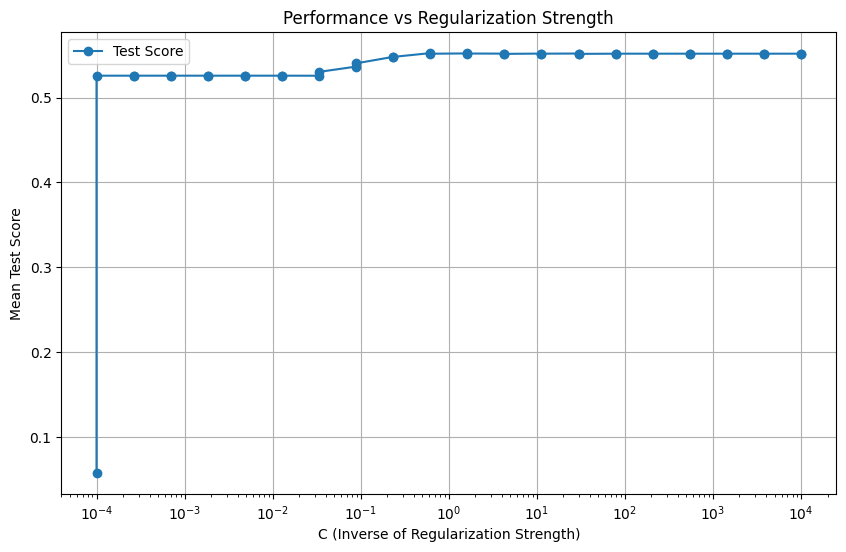

In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss
import numpy as np
import matplotlib.pyplot as plt

# Calculate accuracy
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Accuracy: {accuracy}")

# Calculate log loss
loss = log_loss(y_test_encoded, y_pred_proba)
print(f"Log Loss: {loss}")

# Classification report
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test_encoded, y_pred)
print("Confusion Matrix:")
print(cm)

from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'C': np.logspace(-4, 4, 20),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV
grid_search.fit(X_train_tfidf, y_train_encoded)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

results_df = pd.DataFrame(grid_search.cv_results_)

plt.figure(figsize=(10, 6))
plt.plot(results_df['param_C'], results_df['mean_test_score'], label='Test Score', marker='o')
plt.xscale('log')
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('Mean Test Score')
plt.title('Performance vs Regularization Strength')
plt.legend()
plt.grid(True)
plt.show()


[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Best Parameters: {'C': 1.623776739188721, 'penalty': 'l1', 'solver': 'liblinear'}
Best Accuracy: 0.5589880159786951


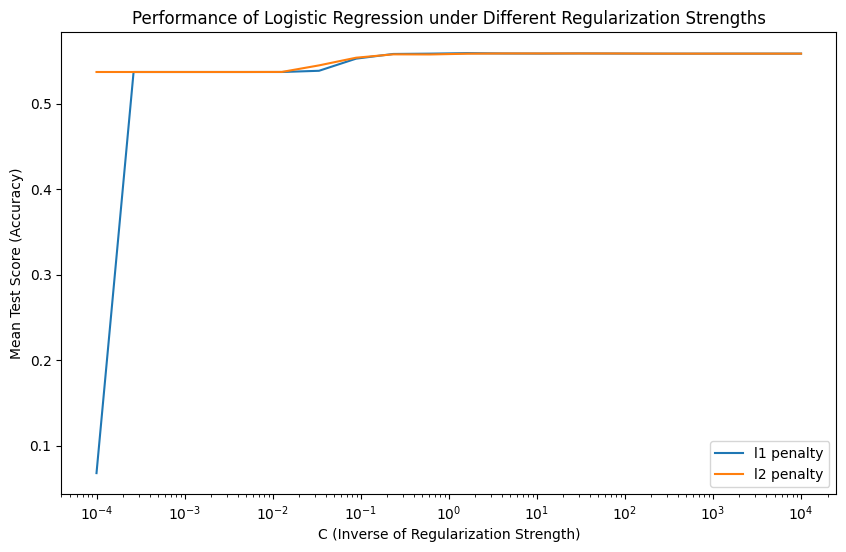

In [27]:
# Model Tuning
# 1. Import Libraries
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, log_loss
import numpy as np
import matplotlib.pyplot as plt

# Download necessary NLTK data
nltk.download('punkt')       
nltk.download('stopwords')  
nltk.download('wordnet')     

# 2. Load and Preprocess Data
data_URL = 'https://raw.githubusercontent.com/Ariamestra/ConsumerReviews/main/Reviews.csv'
df = pd.read_csv(data_URL)
df.dropna(subset=['Review', 'Cons_rating'], inplace=True)
df['Review_length'] = df['Review'].apply(lambda x: len(str(x).split()))
df = df[df['Review_length'] >= 20]

# 3. Feature Engineering
def clean_review(review):
    review = re.sub(r'[^\w\s]', '', review.lower())
    words = word_tokenize(review)
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

df['Processed_Review'] = df['Review'].apply(clean_review)

X_train, X_test, y_train, y_test = train_test_split(df['Processed_Review'], df['Cons_rating'], test_size=0.2, random_state=42)
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', max_df=0.95, min_df=0.05)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# 4. Model Training and Evaluation
lr = LogisticRegression(random_state=42)
param_grid = {'C': np.logspace(-4, 4, 20), 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_tfidf, y_train)

# Best parameters and accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Accuracy: {best_accuracy}")

# 5. Visualization
results_df = pd.DataFrame(grid_search.cv_results_)
plt.figure(figsize=(10, 6))
for penalty in ['l1', 'l2']:
    subset = results_df[results_df['param_penalty'] == penalty]
    plt.plot(subset['param_C'], subset['mean_test_score'], label=f'{penalty} penalty')
plt.xscale('log')
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('Mean Test Score (Accuracy)')
plt.title('Performance of Logistic Regression under Different Regularization Strengths')
plt.legend()
plt.show()


In [28]:
# Bayesian Optimization for Hyperparameter Tuning
#!pip install hyperopt
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.linear_model import LogisticRegression


# Define the search space
space = {
    'C': hp.uniform('C', 0.0001, 10),
    'penalty': hp.choice('penalty', ['l1', 'l2']),
}

# Objective function to minimize
def objective(params):
    model = LogisticRegression(**params, solver='liblinear')
    model.fit(X_train_tfidf, y_train)
    score = model.score(X_test_tfidf, y_test)  # or use cross-validation
    return {'loss': -score, 'status': STATUS_OK}

# Run the algorithm
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

#--------------------------------------------------------------------------------------------
penalty_choice = ['l1', 'l2'][best['penalty']]  # 'best' contains indices for hp.choice

# Train a new model using the best parameters
best_model = LogisticRegression(
    C=best['C'],
    penalty=penalty_choice,
    solver='liblinear'
)
best_model.fit(X_train_tfidf, y_train)

# Calculate accuracy on the test set
best_accuracy = best_model.score(X_test_tfidf, y_test)
print(f"Best Accuracy from best model: {best_accuracy}")
#--------------------------------------------------------------------------------------------

print(f"Best Parameters: {best}")


100%|██████████| 100/100 [00:36<00:00,  2.75trial/s, best loss: -0.5623858794887401]
Best Accuracy from best model: 0.5623858794887401
Best Parameters: {'C': 9.803260068042094, 'penalty': 0}


In [29]:
#Randomized Search for Hyperparameter Tuning

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Define the parameter grid
param_dist = {
    'C': uniform(loc=0, scale=4),  # Uniform distribution in the range [0,4]
    'penalty': ['l2', 'l1'],
    'solver': ['liblinear']
}

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=lr, param_distributions=param_dist, n_iter=100, cv=5, random_state=42)
random_search.fit(X_train_tfidf, y_train)

# Get the best parameters and score
best_params_random = random_search.best_params_
best_score_random = random_search.best_score_

print(f"Best Parameters: {best_params_random}")
print(f"Best Score: {best_score_random}") # accuracy


Best Parameters: {'C': 1.554709158757928, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.5590641050028534


Summerization

In [33]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

# Assume df_cleaned is your DataFrame and it has 'Review' and 'Cons_rating' columns

# Initialize T5 model and tokenizer
#MODEL_NAME = 't5-small'
#t5_model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
#t5_tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

# Function to classify sentiment
def classify_sentiment(rating):
    if rating <= 2:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positive'
'''

# Function to summarize text
def summarize_text(text):
    inputs = tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=512, truncation=True)
    outputs = model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)
'''
# Make sure to import the correct classes for the T5 model
from transformers import T5ForConditionalGeneration, T5Tokenizer

# Initialize T5 model and tokenizer
t5_model = T5ForConditionalGeneration.from_pretrained('t5-small')
t5_tokenizer = T5Tokenizer.from_pretrained('t5-small')

def summarize_text(text):
    # Encode the text into tensor
    inputs = t5_tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=512, truncation=True)
    # Generate the summary with the T5 model
    outputs = t5_model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
    # Decode the tensor to text
    return t5_tokenizer.decode(outputs[0], skip_special_tokens=True)


# Applying sentiment classification
df_cleaned['Sentiment'] = df_cleaned['Cons_rating'].apply(classify_sentiment)
'''
# Applying summarization and calculating word counts
def process_review(row):
    original_review = row['Review']
    summarized_review = summarize_text(original_review)
    sentiment = row['Sentiment']
    original_word_count = len(original_review.split())
    summarized_word_count = len(summarized_review.split())
    
    print(f"Original Review: {original_review}")
    print(f"Sentiment: {sentiment}")
    print(f"Original Review Word Count: {original_word_count}")
    print(f"Summarized Review: {summarized_review}")
    print(f"Summarized Review Word Count: {summarized_word_count}")
    print("\n" + "-"*80 + "\n")

# Assuming df_cleaned is not too large, as this operation can be very time-consuming
df_cleaned.apply(process_review, axis=1)

# Generate summaries for the first 15 rows
df_first_15 = df_cleaned.head(15)
df_first_15['Summary'] = df_first_15['Review'].apply(summarize_text)

# Now, print the details for these 15 summaries
df_first_15.apply(process_review, axis=1)

# Select the first 15 rows of the DataFrame
first_15_reviews = df_cleaned.head(15)
'''
# Iterate over each row in the first 15 reviews
for index, row in df_cleaned.head(15).iterrows():
    original_review = row['Review']
    sentiment = classify_sentiment(row['Cons_rating'])
    summarized_review = summarize_text(original_review)
    original_word_count = len(original_review.split())
    summarized_word_count = len(summarized_review.split())

    print(f"Review {index + 1}:")
    print(f"Original Review: {original_review}")
    print(f"Sentiment: {sentiment}")
    print(f"Original Review Word Count: {original_word_count}")
    print(f"Summarized Review: {summarized_review}")
    print(f"Summarized Review Word Count: {summarized_word_count}")
    print("\n" + "-"*80 + "\n")




Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Review 2:
Original Review: Love this dress!  it's sooo pretty.  i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite.  i bought a petite and am 5'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.
Sentiment: positive
Original Review Word Count: 62
Summarized Review: i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8" and i love the length on me.
Summarized Review Word Count: 29

--------------------------------------------------------------------------------

Review 3:
Original Review: I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but t

## Conclusion
In conclusion, the project has successfully used the pre-trained T5 model to transform extensive customer reviews into brief summaries. This advancement not only enhances the efficiency of user evaluations by providing understanding into product feedback. The implementation of this summarization tool shows practical use of text-to-text transformers in real-world scenarios, simplifying the decision-making process for consumers.